### Sentiment analysis using Vader

In [1]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from tabulate import tabulate
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaModel
import warnings
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os

# Set the working directory to the previous directory
os.chdir('..')

nltk.download('vader_lexicon',quiet=True)

True

In [2]:
df = pd.read_csv('./data/lyrics_proc_train.csv')
sia = SentimentIntensityAnalyzer()

In [3]:
"""
apply sentiment analysis:
polarity_scores() returns a dictionary with four key sentiment metrics that
provide a comprehensive view of the sentiment:

- neg (negative): proportion of text that is perceived as negative
    range:  0-1   ->  higher values indicate a stronger presence of negative sentiment

- neu (neutral): proportion of text that is perceived as neutral
    range:  0-1   ->  higher values indicate a stronger presence of neutral sentiment

- pos (positive): proportion of text that is perceived as positive
    range:  0-1   ->  higher values indicate a stronger presence of positive sentiment

-compound: normalized, weighted composite score that summarizes the overall sentiment of the text
    range: -1, 1  ->    Values close to 1 indicate extremely positive sentiment.
                        Values close to -1 indicate extremely negative sentiment.
                        Values around 0 indicate neutral sentiment.
"""

df['sentiment'] = df['lyrics_proc'].apply(lambda x: sia.polarity_scores(x))

# separate the sentiment scores into individual columns
sentiment_df = df['sentiment'].apply(pd.Series)

df = pd.concat([df, sentiment_df], axis=1)

# Drop the 'sentiment' column
df.drop(columns=['sentiment'], inplace=True)

columns_to_display = ['title', 'artist', 'neg', 'neu', 'pos', 'compound']

print(tabulate(df[columns_to_display].head(), headers='keys', tablefmt='pretty'))

+---+-------------------------+-------------+-------+-------+-------+----------+
|   |          title          |   artist    |  neg  |  neu  |  pos  | compound |
+---+-------------------------+-------------+-------+-------+-------+----------+
| 0 |       Let It Rock       |  Bon Jovi   | 0.054 | 0.574 | 0.372 |  0.9648  |
| 1 |        Music Box        |   Eminem    | 0.073 | 0.753 | 0.175 |  0.9856  |
| 2 |     Redemption Day      | Johnny Cash | 0.242 | 0.527 | 0.23  | -0.4303  |
| 3 | Party (Homecoming Live) |   Beyonce   | 0.129 | 0.511 | 0.36  |  0.9726  |
| 4 |    I Came To Believe    | Johnny Cash | 0.144 | 0.591 | 0.265 |  0.8126  |
+---+-------------------------+-------------+-------+-------+-------+----------+


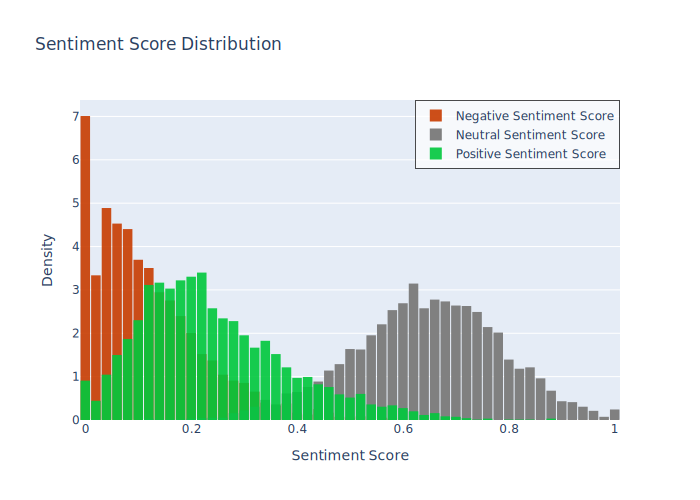

In [5]:
# Create figure
fig = go.Figure()

# Add subplot for negative scores
fig.add_trace(go.Histogram(x=df['neg'], nbinsx=50,histnorm='probability density', name='Negative Sentiment Score',marker_color='rgba(200, 60, 0, 0.9)'))

# Add subplot for neutral scores
fig.add_trace(go.Histogram(x=df['neu'], nbinsx=50,histnorm='probability density', name='Neutral Sentiment Score',opacity=1,marker_color='grey'))

# Add subplot for positive scores
fig.add_trace(go.Histogram(x=df['pos'], nbinsx=50,histnorm='probability density', name='Positive Sentiment Score',marker_color='rgba(0, 200, 60, 0.9)'))

# Update layout
fig.update_layout(
    title='Sentiment Score Distribution',
    xaxis_title='Sentiment Score',
    yaxis_title='Density',
    barmode='overlay',
    bargap=0.1,
    legend=dict(x=0.62, y=1, bgcolor='rgba(255,255,255,0.7)', bordercolor='rgba(0,0,0,0.7)', borderwidth=1),
)

# Show plot
fig.show('svg')
# Save plot
pio.write_image(fig, './plots/sentiment_score_dist.pdf')

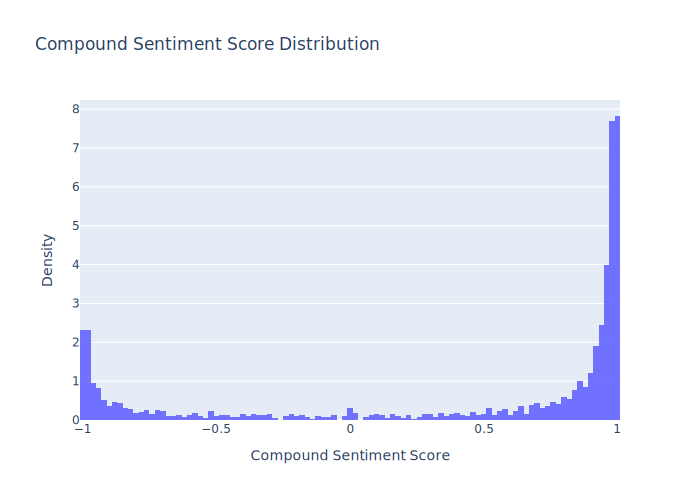

In [7]:
# Create histogram trace
histogram_trace = go.Histogram(x=df['compound'], nbinsx=100, histnorm='probability density', name='Compound Sentiment Score', marker_color='rgba(100, 100, 255, 0.9)')

# Create figure
fig = go.Figure(histogram_trace)

# Update layout
fig.update_layout(
    title='Compound Sentiment Score Distribution',
    xaxis_title='Compound Sentiment Score',
    yaxis_title='Density',
)

# Show plot
fig.show('svg')
# Save plot
pio.write_image(fig, './plots/compound_sentiment_score_dist.pdf')

### Topic modeling with LDA

In [8]:
# Load the trained LDA model
lda_model = LdaModel.load('./models/others/lda_model.gensim')

# Load the dictionary
dictionary = corpora.Dictionary.load('./models/others/dictionary.gensim')

# Load the corpus
corpus = corpora.MmCorpus('./models/others/corpus.mm')

In [9]:
# Print the most relevant keywords for each topic
topics = lda_model.print_topics(num_topics=lda_model.num_topics, num_words=3)
for topic in topics:
    print(topic)

(0, '0.028*"like" + 0.021*"nigga" + 0.016*"fuck"')
(1, '0.010*"christma" + 0.010*"come" + 0.009*"night"')
(2, '0.037*"love" + 0.026*"know" + 0.016*"never"')
(3, '0.047*"babi" + 0.028*"girl" + 0.025*"want"')
(4, '0.015*"like" + 0.011*"well" + 0.010*"come"')


In [ ]:
"""
# Measure coherence within a topic
coherencemodel = CoherenceModel(model=lda_model, texts=corpus, dictionary=dictionary, coherence='c_v')
# Suppress warnings temporarily
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #my_function_that_generates_warnings()
    print(coherencemodel.get_coherence())
"""

In [12]:
test_lyric = df['lyrics_proc'][0]

# Convert the preprocessed test lyric into a bag-of-words representation
test_bow = dictionary.doc2bow(test_lyric.split())

# Apply the trained LDA model to the test lyric
topic_distribution = lda_model.get_document_topics(test_bow)

# Get the topic with the highest score
highest_topic = max(topic_distribution, key=lambda x: x[1])
print(highest_topic)

# Get the main keywords for the highest topic
main_keywords = lda_model.show_topic(highest_topic[0], topn=5)

# Return the representation through the main keywords
representation = [keyword[0] for keyword in main_keywords]
representation

(4, 0.56509906)


['like', 'well', 'come', 'said', 'call']

In [13]:
# Get topic distributions
df['lda'] = [lda_model.get_document_topics(bow) for bow in corpus]
df.head()['lda']

0    [(1, 0.17169867), (2, 0.14107515), (3, 0.11908...
1    [(0, 0.32622835), (1, 0.3847771), (2, 0.184396...
2    [(1, 0.40363222), (2, 0.39864072), (4, 0.19380...
3    [(0, 0.23034556), (1, 0.06798923), (2, 0.21058...
4                    [(1, 0.29243812), (2, 0.6971464)]
Name: lda, dtype: object

In [14]:
#with warnings.catch_warnings():
#warnings.simplefilter("ignore")
pyLDAvis.enable_notebook()

# Convert the corpus to a gensim-specific format
gensim_corpus = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(gensim_corpus)

/home/aresta/miniconda3/envs/nlp/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=3052668) is multi-threaded, use of fork() may lead to deadlocks in the child.

/home/aresta/miniconda3/envs/nlp/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=3052668) is multi-threaded, use of fork() may lead to deadlocks in the child.

/home/aresta/miniconda3/envs/nlp/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=3052668) is multi-threaded, use of fork() may lead to deadlocks in the child.

/home/aresta/miniconda3/envs/nlp/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=3052668) is multi-threaded, use of fork() may lead to deadlocks in the child.

/home/aresta/miniconda3/envs/nlp/lib/python3.12/site-packages/joblib/externals/loky/backend/

### TF-IDF

In [15]:

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# the corpus is the whole list of lyrics processed
corpus = df['lyrics_proc'].values

print("Corpus: ", len(corpus), "\n")

tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to a list of lists
tfidf_list = tfidf_matrix.toarray().tolist()

# Add TF-IDF vector list as a column named 'tf-idf'
df['tf-idf'] = tfidf_list

print("Number of features: %d" % len(feature_names), "\n")
print("Last 10 features: ", feature_names[-10:], "\n")
print ("Dimensions of the TF-IDF matrix: ", tfidf_matrix.shape, "\n")

Corpus:  4736 

Number of features: 18330 

Last 10 features:  ['¾ã' 'ãªtre' 'ä¹' 'äººã' 'ä¼' 'ä½' 'æ²' 'è²' 'êµ' 'ï¼'] 

Dimensions of the TF-IDF matrix:  (4736, 18330) 



### Combine the three features into a single fixed-size vector

In [16]:
# Convert LDA topic distributions to a fixed-size vector
def lda_to_vec(lda_dist, num_topics):
    vec = np.zeros(num_topics)
    for topic, prob in lda_dist:
        vec[topic] = prob
    return vec

# Combine features
features = []
for i in range(len(df)):
    sentiment_scores = df[['neg', 'neu', 'pos', 'compound']].iloc[i].values
    lda_vector = lda_to_vec(df['lda'].iloc[i], lda_model.num_topics)
    tfidf_vector = tfidf_matrix[i].toarray()[0]
    
    combined_vector = np.concatenate([sentiment_scores, lda_vector, tfidf_vector])
    features.append(combined_vector.tolist())

# Convert to numpy array
df['feature_vector'] = features
df.head()

,id,artist,title,lyrics,lyrics_proc,neg,neu,pos,compound,lda,tf-idf,feature_vector
0,7828,Bon Jovi,Let It Rock,\n\r\nThe weekend comes to this town \r\nSeven...,weekend come town seven soon make break rule w...,0.054,0.574,0.372,0.9648,"[(1, 0.17169867), (2, 0.14107515), (3, 0.11908...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.054, 0.574, 0.372, 0.9648, 0.0, 0.171698674..."
1,2706,Eminem,Music Box,"\n\r\nYeah, girl.\nCan you hear that?\nIt's pl...",girl hear play song sleepi take afraid dark he...,0.073,0.753,0.175,0.9856,"[(0, 0.32622835), (1, 0.3847771), (2, 0.184396...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.073, 0.753, 0.175, 0.9856, 0.32622835040092..."
2,4658,Johnny Cash,Redemption Day,\n\r\nI've wept for those who suffer long\r\nB...,wept suffer long weep gone room grief question...,0.242,0.527,0.230,-0.4303,"[(1, 0.40363222), (2, 0.39864072), (4, 0.19380...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.242, 0.527, 0.23, -0.4303, 0.0, 0.403632223..."
3,14321,Beyonce,Party (Homecoming Live),"\n\r\nI may be young, but I'm ready\nTo give y...",young readi give love told girl slow love give...,0.129,0.511,0.360,0.9726,"[(0, 0.23034556), (1, 0.06798923), (2, 0.21058...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.129, 0.511, 0.36, 0.9726, 0.230345562100410..."
4,4352,Johnny Cash,I Came To Believe,\n\r\nI couldn't manage the problems I laid on...,could manag problem laid made wors laid somebo...,0.144,0.591,0.265,0.8126,"[(1, 0.29243812), (2, 0.6971464)]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.144, 0.591, 0.265, 0.8126, 0.0, 0.292438119..."


### Here we directly apply cosine similarity and retrieve the most similar songs

In [17]:
def top_n_similar_embeddings(df, target_index, n=10):
    
    # Extract the target embedding and its cluster
    target_embedding = df.at[target_index, 'feature_vector']
    
    # Get all the embeddings    
    all_embeddings = np.stack(df['feature_vector'].values)

    # Calculate cosine similarities
    similarities = cosine_similarity([target_embedding], all_embeddings)[0]

    # Get the top n similar embeddings
    top_n_indices = np.argsort(similarities)[-n-1:][::-1]
    top_n_similar_ids = df.iloc[top_n_indices]['id'].values
    top_n_similarities = similarities[top_n_indices]

    return pd.DataFrame({
        'id': top_n_similar_ids, 
        'similarity': top_n_similarities
    })

# Show top 10 similar song to the first song (the first row is the song itself)
top_n_similar_embeddings(df,target_index=0,n=10)

,id,similarity
0,7828,1.000000
1,17871,0.807574
2,23723,0.746321
3,24752,0.722830
4,6933,0.719819
5,17590,0.719181
6,617,0.718872
7,993,0.718871
8,18288,0.705612
9,16549,0.698643
